In [2]:
import os
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString # , Point
# import requests
# from bs4 import BeautifulSoup
# import matplotlib.pyplot as plt

import shanghai_bus_line
import CoordinatesConverter

# 1 线路数据读取

直接从网页上copy的数据

In [5]:
line_71_json = json.loads(shanghai_bus_line.get_line_71())

line_20_json = json.loads(shanghai_bus_line.get_line_20())
line_23_json = json.loads(shanghai_bus_line.get_line_23())
line_54_json = json.loads(shanghai_bus_line.get_line_54())
line_64_json = json.loads(shanghai_bus_line.get_line_64())
line_66_json = json.loads(shanghai_bus_line.get_line_66())
line_88_json = json.loads(shanghai_bus_line.get_line_88())
line_109_json = json.loads(shanghai_bus_line.get_line_109())
line_210_json = json.loads(shanghai_bus_line.get_line_210())
line_930_json = json.loads(shanghai_bus_line.get_line_930())

# 2 信息提取区

In [6]:
def get_bus_info(line_json):
    '''分别获取上行、下行数据'''
    # Line GIS
    # 线路名称
    line_name = line_json['data']['keywords']
    print('线路名称：', line_name)
    
    ### 上行
    print('---上行线路信息---')
    # 起讫站点名称
    front_name  = line_json['data']['busline_list'][0]['front_name']
    terminal_name = line_json['data']['busline_list'][0]['terminal_name']
    print('起点站：', front_name)
    print('终点站：', terminal_name)
    
    # 线路线型
    lon_list = line_json['data']['busline_list'][0]['xs'].split(',')
    lat_list = line_json['data']['busline_list'][0]['ys'].split(',')
    print('线型点数量（经度）：', len(lon_list))
    print('线型点数量（纬度）：', len(lat_list))
    
    # 沿线站点信息
    station_name = []
    station_idx = []
    station_lon = []
    station_lat = []
    idx = 0
    for each_station in line_json['data']['busline_list'][0]['stations']:
        station_name.append(each_station['name'])
        station_idx.append(each_station['station_id'])
        station_lon.append(each_station['xy_coords'].split(';')[0])
        station_lat.append(each_station['xy_coords'].split(';')[1])

    print(station_name)
    print('站点数：', len(station_name))
    
    ### 下行
    print('---下行线路信息---')
    # 起讫站点名称
    front_name_1  = line_json['data']['busline_list'][1]['front_name']
    terminal_name_1 = line_json['data']['busline_list'][1]['terminal_name']
    print('起点站：', front_name_1)
    print('终点站：', terminal_name_1)
    
    # 线路线型
    lon_list_1 = line_json['data']['busline_list'][1]['xs'].split(',')
    lat_list_1 = line_json['data']['busline_list'][1]['ys'].split(',')
    print('线型点数量（经度）：', len(lon_list_1))
    print('线型点数量（纬度）：', len(lat_list_1))
    
    # 沿线站点信息
    station_name_1 = []
    station_idx_1 = []
    station_lon_1 = []
    station_lat_1 = []
    idx = 0
    for each_station in line_json['data']['busline_list'][1]['stations']:
        station_name_1.append(each_station['name'])
        station_idx_1.append(each_station['station_id'])
        station_lon_1.append(each_station['xy_coords'].split(';')[0])
        station_lat_1.append(each_station['xy_coords'].split(';')[1])

    print(station_name)
    print('站点数：', len(station_name))
    return line_name, front_name, terminal_name, lon_list, lat_list, \
station_name, station_idx, station_lon, station_lat, \
front_name_1, terminal_name_1, lon_list_1, lat_list_1, \
station_name_1, station_idx_1, station_lon_1, station_lat_1

### 71路

In [7]:
line_name, front_name, terminal_name, lon_list, lat_list, \
station_name, station_idx, station_lon, station_lat, \
front_name_1, terminal_name_1, lon_list_1, lat_list_1, \
station_name_1, station_idx_1, station_lon_1, station_lat_1 = \
get_bus_info(line_71_json)

线路名称： 71路
---上行线路信息---
起点站： 申昆路枢纽站
终点站： 延安东路外滩
线型点数量（经度）： 391
线型点数量（纬度）： 391
['申昆路枢纽站', '吴宝路', '航新路', '航东路', '外环路', '虹井路', '剑河路', '虹梅路', '虹许路', '水城南路', '娄山关路', '凯旋路', '定西路', '番禺路', '江苏路', '镇宁路', '华山路', '常德路', '上海展览中心', '茂名北路', '成都北路', '黄陂北路', '西藏中路', '河南中路', '延安东路外滩']
站点数： 25
---下行线路信息---
起点站： 延安东路外滩
终点站： 申昆路枢纽站
线型点数量（经度）： 374
线型点数量（纬度）： 374
['申昆路枢纽站', '吴宝路', '航新路', '航东路', '外环路', '虹井路', '剑河路', '虹梅路', '虹许路', '水城南路', '娄山关路', '凯旋路', '定西路', '番禺路', '江苏路', '镇宁路', '华山路', '常德路', '上海展览中心', '茂名北路', '成都北路', '黄陂北路', '西藏中路', '河南中路', '延安东路外滩']
站点数： 25


# 3 形成线路的GeoPandas数据

In [12]:
def get_geodataframe(line_name, front_name, terminal_name, lon_list, lat_list, 
                     station_name, station_idx, station_lon, station_lat, 
                     front_name_1, terminal_name_1, lon_list_1, lat_list_1, 
                     station_name_1, station_idx_1, station_lon_1, station_lat_1
                    ): 
    # Part 1-1: Line_SHP 上行
    # DF 
    num_point = len(lon_list)
    df_line = pd.DataFrame({'line_name': [line_name] * num_point,
                            'direction': [front_name + '-' + terminal_name] * num_point, 
                            'lon': lon_list,
                            'lat': lat_list,
                           })
    
    # 高德转 WGS84
    df_line['lon'], df_line['lat'] = \
    CoordinatesConverter.gcj02towgs84(df_line['lon'].astype(float), df_line['lat'].astype(float))
    
    # 生成路径
    path = 'sh_bus_shp_' + line_name.split('路')[0]
    if not os.path.exists(path):
        os.makedirs(path)
    
    # to_csv
    df_line.to_csv(path + '/line_' + line_name.split('路')[0] + '_dir0_WGS84_gbk.csv', index=None, encoding='gbk')
    df_line.to_csv(path + '/line_' + line_name.split('路')[0] + '_dir0_WGS84_utf8.csv', index=None, encoding='utf-8')
    
    # LineString
    gdf_line = gpd.GeoDataFrame(
    df_line, geometry=gpd.points_from_xy(df_line.lon, df_line.lat))
    
    # 输出成SHP文件
    gdf_line.to_file(path + '/line_' + line_name.split('路')[0] + '_dir0_WGS84_utf8.shp', encoding='utf-8')
    
    # LineString
    # 暂时不用到
    # xyList = [xy for xy in zip(gdf_line.lon, gdf_line.lat)]
    # line = LineString(xyList)
    # line
    
    # Part 1-2: Line_SHP 上行
    # DF 
    num_point_1 = len(lon_list_1)
    df_line_1 = pd.DataFrame({'line_name': [line_name] * num_point_1,
                            'direction': [front_name_1 + '-' + terminal_name_1] * num_point_1, 
                            'lon': lon_list_1,
                            'lat': lat_list_1,
                           })
    
    # 高德转 WGS84
    df_line_1['lon'], df_line_1['lat'] = \
    CoordinatesConverter.gcj02towgs84(df_line_1['lon'].astype(float), df_line_1['lat'].astype(float))
    
    # 生成路径
    path = 'sh_bus_shp_' + line_name.split('路')[0]
    if not os.path.exists(path):
        os.makedirs(path)
    
    # to_csv
    df_line_1.to_csv(path + '/line_' + line_name.split('路')[0] + '_dir1_WGS84_gbk.csv', index=None, encoding='gbk')
    df_line_1.to_csv(path + '/line_' + line_name.split('路')[0] + '_dir1_WGS84_utf8.csv', index=None, encoding='utf-8')
    
    # LineString
    gdf_line_1 = gpd.GeoDataFrame(
        df_line_1, geometry=gpd.points_from_xy(df_line_1.lon, df_line_1.lat))
    
    # 输出成SHP文件
    gdf_line_1.to_file(path + '/line_' + line_name.split('路')[0] + '_dir1_WGS84_utf8.shp', encoding='utf-8')
    
    
    # Part 2: Station_SHP
    df_station = pd.DataFrame({'station_name': station_name + station_name_1,
                               'direction': [front_name + '-' + terminal_name] * len(station_name) + 
                                            [front_name_1 + '-' + terminal_name_1] * len(station_name_1),
                               'ToDir': [0] * len(station_name) + [1] * len(station_name_1), 
                               'station_idx': station_idx + station_idx_1, 
                               'station_lon': station_lon + station_lon_1,
                               'station_lat': station_lat + station_lat_1,
                      })
    
    # 高德转 WGS84
    df_station['station_lon'], df_station['station_lat'] = \
    CoordinatesConverter.gcj02towgs84(df_station['station_lon'].astype(float), 
                                      df_station['station_lat'].astype(float))
    
    df_station.to_csv(path + '/line_' + line_name.split('路')[0] + '_station_WGS84_gbk.csv', 
                      index=None, encoding='gbk')
    df_station.to_csv(path + '/line_' + line_name.split('路')[0] + '_station_WGS84_utf8.csv', 
                      index=None, encoding='utf-8')
    
    gdf_station = gpd.GeoDataFrame(
        df_station, geometry=gpd.points_from_xy(df_station.station_lon, 
                                                df_station.station_lat))
    # Station SHP
    gdf_station.to_file(path + '/line_' + line_name.split('路')[0] + '_station_WGS84_gbk.shp', encoding='utf-8')
    
    return gdf_line, gdf_line_1, gdf_station


# 4. 输出所有线路

线路名称： 71路
---上行线路信息---
起点站： 申昆路枢纽站
终点站： 延安东路外滩
线型点数量（经度）： 391
线型点数量（纬度）： 391
['申昆路枢纽站', '吴宝路', '航新路', '航东路', '外环路', '虹井路', '剑河路', '虹梅路', '虹许路', '水城南路', '娄山关路', '凯旋路', '定西路', '番禺路', '江苏路', '镇宁路', '华山路', '常德路', '上海展览中心', '茂名北路', '成都北路', '黄陂北路', '西藏中路', '河南中路', '延安东路外滩']
站点数： 25
---下行线路信息---
起点站： 延安东路外滩
终点站： 申昆路枢纽站
线型点数量（经度）： 374
线型点数量（纬度）： 374
['申昆路枢纽站', '吴宝路', '航新路', '航东路', '外环路', '虹井路', '剑河路', '虹梅路', '虹许路', '水城南路', '娄山关路', '凯旋路', '定西路', '番禺路', '江苏路', '镇宁路', '华山路', '常德路', '上海展览中心', '茂名北路', '成都北路', '黄陂北路', '西藏中路', '河南中路', '延安东路外滩']
站点数： 25
线路名称： 20路
---上行线路信息---
起点站： 中山公园(万航渡路)
终点站： 汉口路四川中路
线型点数量（经度）： 243
线型点数量（纬度）： 243
['中山公园(万航渡路)', '华阳路长宁路', '愚园路安西路', '愚园路江苏路', '愚园路镇宁路', '愚园路乌鲁木齐北路', '静安寺', '南京西路陕西北路', '上海电视台', '南京西路成都北路', '南京西路黄河路', '九江路浙江中路', '汉口路四川中路']
站点数： 13
---下行线路信息---
起点站： 汉口路四川中路
终点站： 中山公园(万航渡路)
线型点数量（经度）： 269
线型点数量（纬度）： 269
['中山公园(万航渡路)', '华阳路长宁路', '愚园路安西路', '愚园路江苏路', '愚园路镇宁路', '愚园路乌鲁木齐北路', '静安寺', '南京西路陕西北路', '上海电视台', '南京西路成都北路', '南京西路黄河路', '九江路浙江中路', '汉口路四川中路']
站点数： 13
线路名称

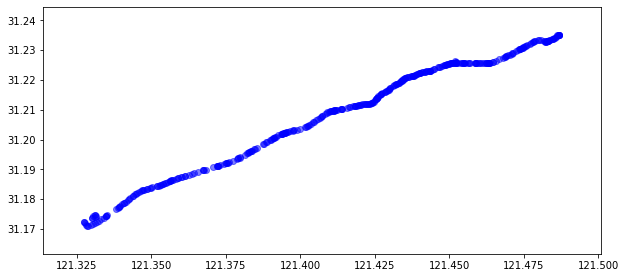

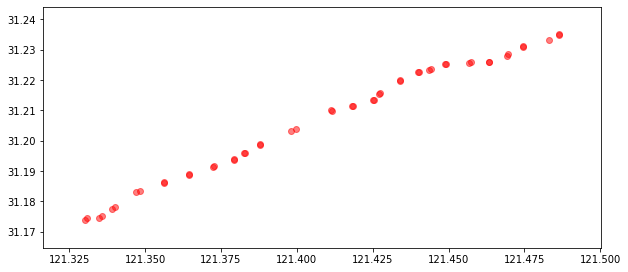

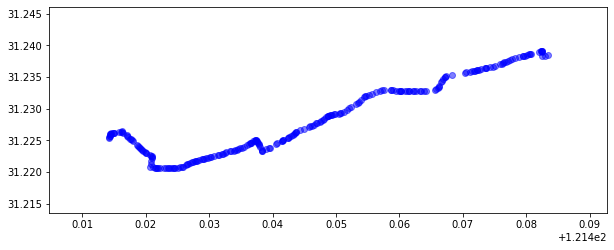

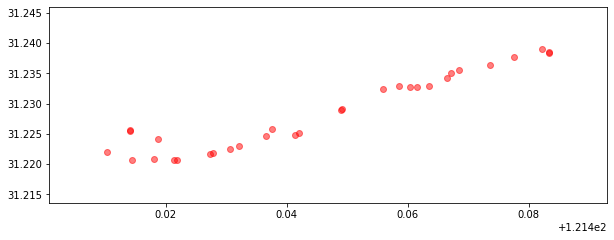

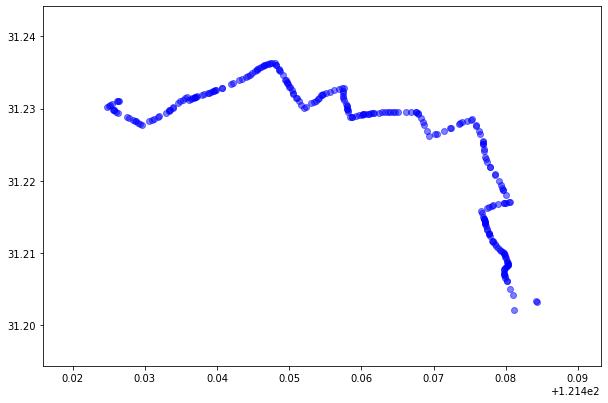

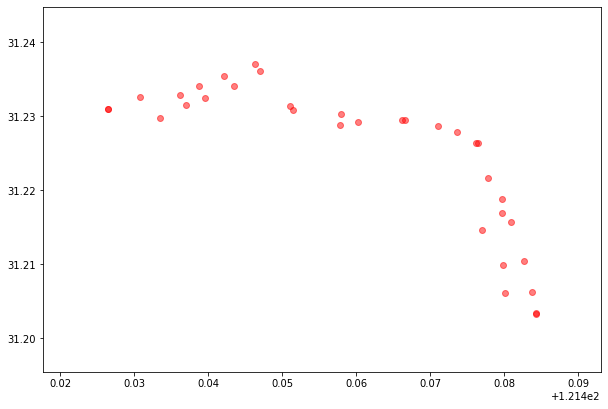

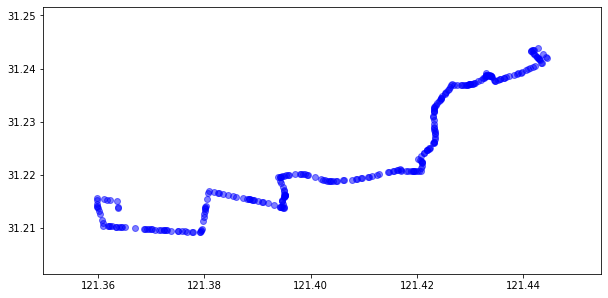

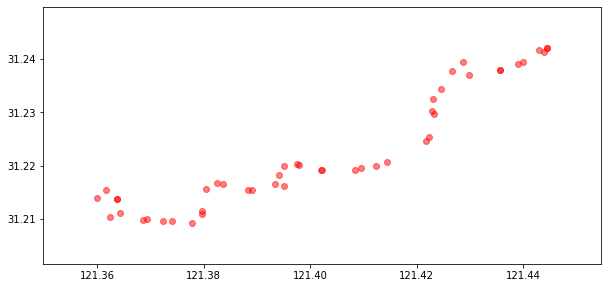

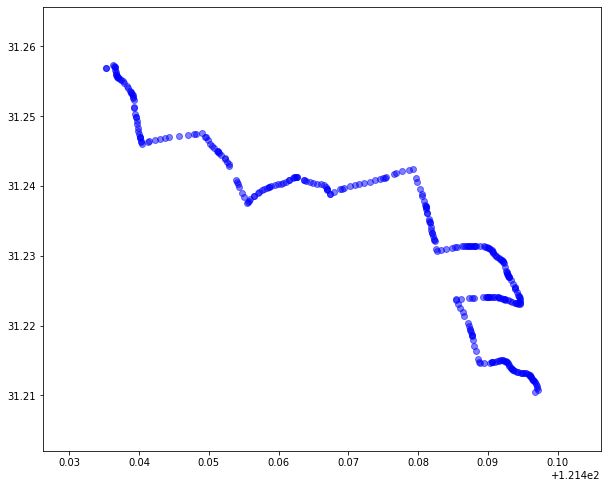

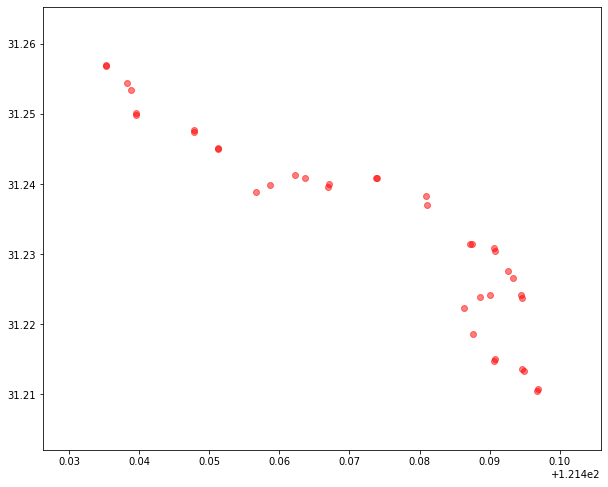

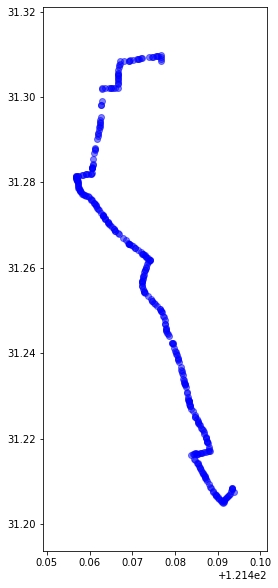

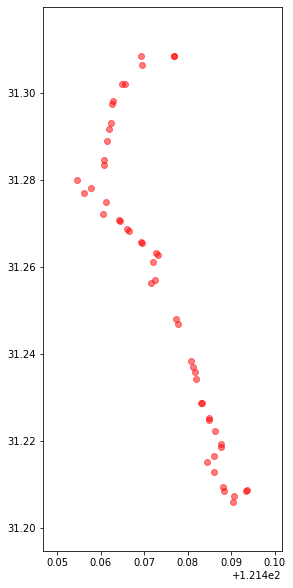

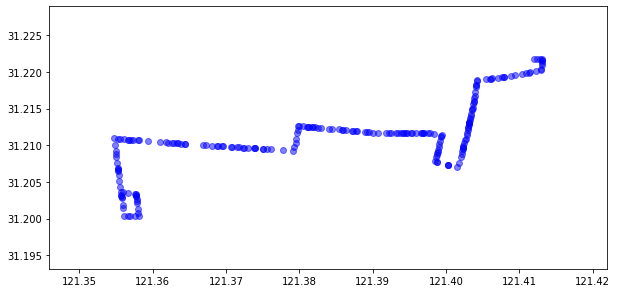

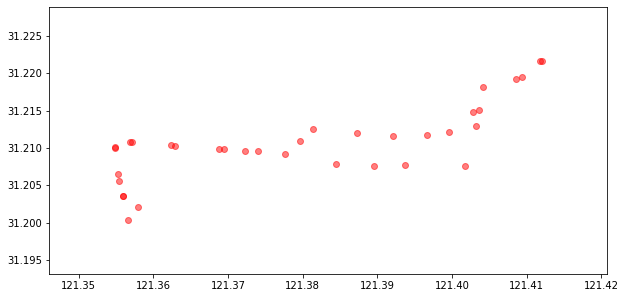

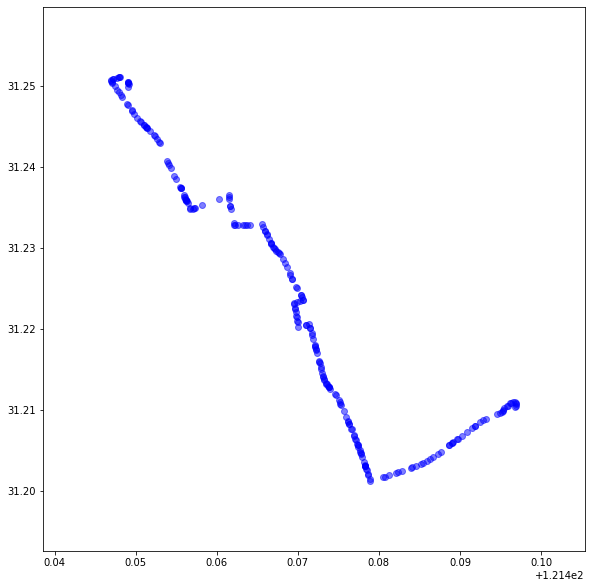

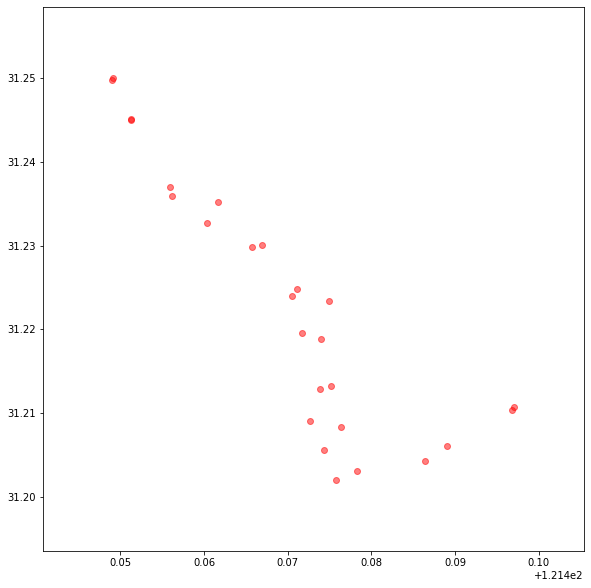

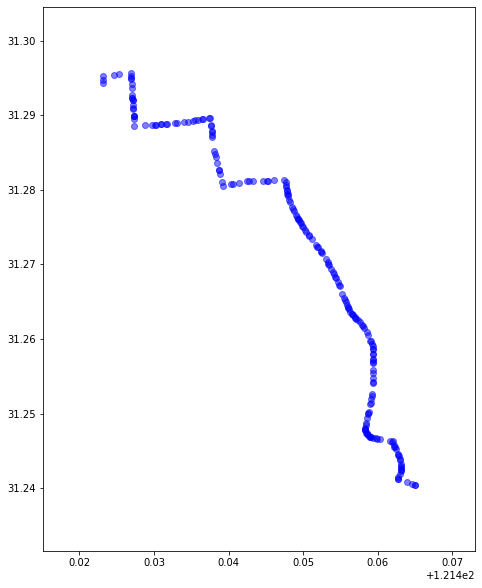

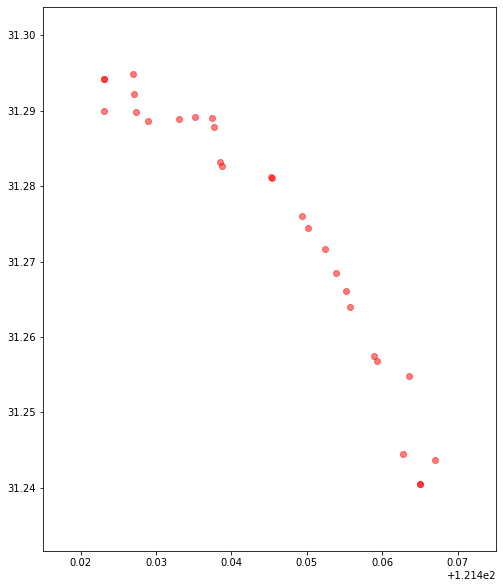

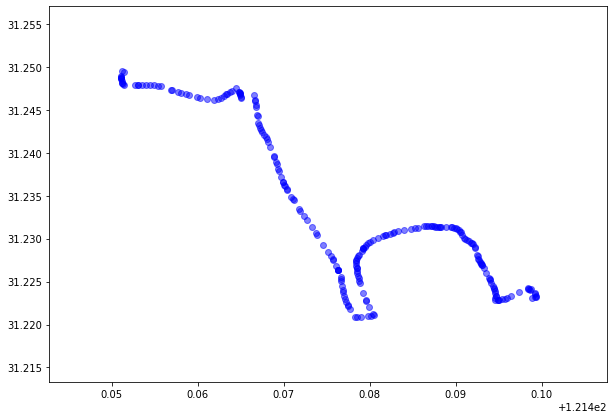

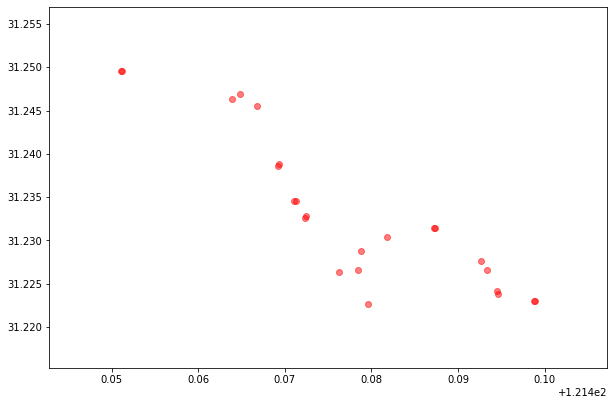

In [13]:
for line_json in [line_71_json, line_20_json, line_23_json, 
             line_54_json, line_64_json, line_66_json, 
             line_88_json, line_109_json, line_210_json, line_930_json
            ]:
    line_name, front_name, terminal_name, lon_list, lat_list, \
station_name, station_idx, station_lon, station_lat, \
front_name_1, terminal_name_1, lon_list_1, lat_list_1, \
station_name_1, station_idx_1, station_lon_1, station_lat_1 = \
get_bus_info(line_json)
    
    gdf_line, gdf_line_1, gdf_station = \
    get_geodataframe(line_name, front_name, terminal_name, lon_list, lat_list, 
                     station_name, station_idx, station_lon, station_lat,
                     front_name_1, terminal_name_1, lon_list_1, lat_list_1, 
                     station_name_1, station_idx_1, station_lon_1, station_lat_1
                        )
    

## 站点的地图可视化

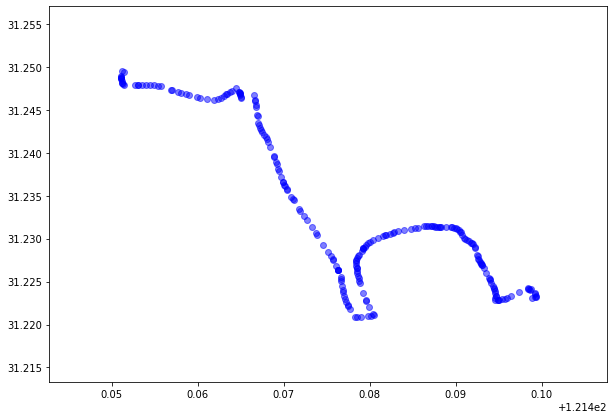

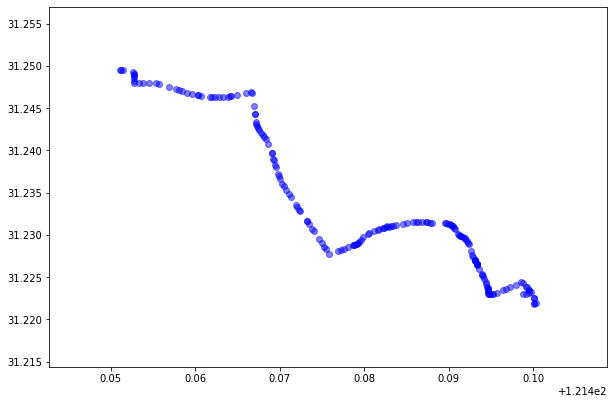

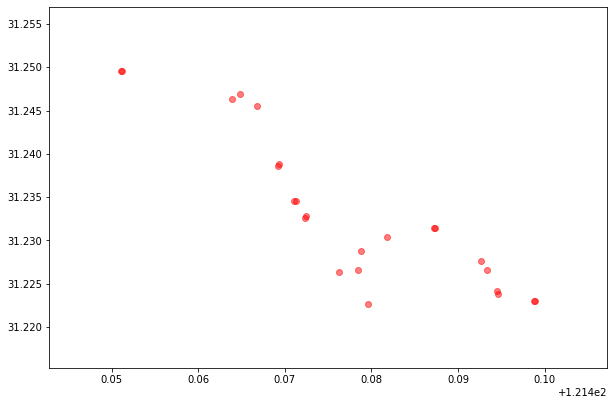

In [15]:
gdf_line.plot(figsize=(10, 10), alpha=0.5, color='blue')
gdf_line_1.plot(figsize=(10, 10), alpha=0.5, color='blue')
gdf_station.plot(figsize=(10, 10), alpha=0.5, color='red')